# Measuring galaxy shapes

***

## Imports
 Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *asdf* for accessing Advanced Scientific Data Format (ASDF) files
- *astropy.table Table* for manipulating tabulated data
- *matplotlib.pyplot* for plotting data
- *matplotlib.colors.LogNorm* to represent 2D arrays in log-scale.
- *gwcs* to perform sky-to-detector coordinate transformations.
- *astropy.coordinates* to perform sky-to-detector coordinate transformations.
- *webbpsf* to access Roman's point-spread function.
- *galsim* to measure source moments and generate Sérsic profiles.
- *romanisim.bandpass.get_abflux* to convert flux from maggies to photons/s consistently with our simulation.
- *scipy.optimize.curve_fit* to fit our data.

In [1]:
import numpy as np
import asdf
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import webbpsf
import galsim
import gwcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from romanisim.bandpass import get_abflux
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
import os
os.environ['WEBBPSF_PATH']="/grp/jwst/ote/webbpsf-data"

## Introduction
The main goal of this notebook is to illustrate a typical usage case of Roman images, which is performing shape measurements of astronomical sources. 

We are going to perform two sets of measurements. First, we rely on [`galsim`](https://galsim-developers.github.io/) to perform ellipticity measurements. In particular, we use the
[REGAUSS method in its HSM module](https://galsim-developers.github.io/GalSim/_build/html/hsm.html) ([Hirata & Seljak 2003](https://ui.adsabs.harvard.edu/abs/2003MNRAS.343..459H/abstract), [Mandelbaum et al. 2005](https://ui.adsabs.harvard.edu/abs/2005MNRAS.361.1287M/abstract)). Second, we fit a galaxy cutout to a Sérsic model.

This notebook relies on Advanced Scientific Data Format (`ASDF`) file manipulations. For additional information about these files
and how to use them, please check our `exploring_ASDF` notebook.

### Defining terms

- ASDF: Advanced Scientific Data Format -- the current preferred data format for Roman's Science Pipelines.

***

## Loading data
The first step of the analysis is to read the Roman image data, which are stored in ASDF format. For this example we start with a calibrated level-2 simulated image created with [`romanisim`](https://romanisim.readthedocs.io). For more information about Roman's data products check the [Roman User Documentation](roman-docs.stsci.edu).

In [3]:
# This  will change when the data are elsewhere
img_path = '/grp/roman/SCIENCE_PLATFORM_DATA/ROMANISIM/DENSE_REGION/R0.5_DP0.5_PA0/r0000101001001001001_01101_0001_WFI01_cal.asdf'
img_asdf = asdf.open(img_path)

The idea to perform these measurements is to get image cutouts of the individual sources, and perform our measurements. There are many options to get the cutouts. We choose to use the input catalog from the simulation software to define our cutouts. In a more realistic scenario, we would run a detection algorithm to create the cutouts.

We start by saving the image array in the `img_arr` variable. Remember that the `data` datablock in the ASDF files typically contain the data arrays, and these typically are `astropy.quantity.Quantity` objects with units and values. We are just interested in the value of the image (in DN/s/px).

In [4]:
img_arr = img_asdf['roman']['data'][:, :].value
print('The units of the original data are: ', img_asdf['roman']['data'].unit)

The units of the original data are:  DN / s


We read the input catalog using `astropy.table`. More details about these catalogs are available [here](https://romanisim.readthedocs.io/en/latest/romanisim/catalog.html).

In [5]:
cat_path = '/grp/roman/SCIENCE_PLATFORM_DATA/ROMANISIM/DENSE_REGION/R0.5_DP0.5_PA0/fullcat_101M_pared_ra0.50_dec0.50_WFI01.ecsv'
catalog = Table.read(cat_path, format='ascii.ecsv')

As a quick sanity check we plot the positions of 1% of the objects

Text(0, 0.5, 'Dec [deg]')

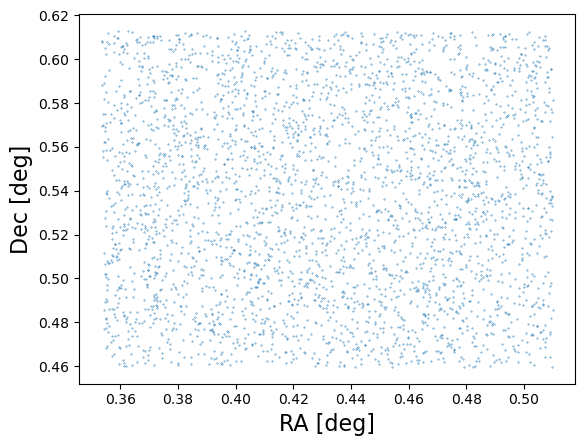

In [6]:
plt.scatter(catalog['ra'][::100], catalog['dec'][::100], s=0.1)
plt.xlabel('RA [deg]', fontsize=16)
plt.ylabel('Dec [deg]', fontsize=16)

## Creating cutouts and retrieving `webbpsf`'s PSF.

The positions are in sky coordinates. In order to make the cutouts we need the pixel coordinates in the image. In order to do that, we use the input World Coordinate System (WCS).
In the case of Roman data, these correspond to GWCS objects. For more information about GWCS please check the documentation [here](https://gwcs.readthedocs.io/).

In [7]:
w = img_asdf['roman']['meta']['wcs'] # We call the GWCS object w for later usage

In [8]:
coords = SkyCoord(ra=catalog['ra']*u.deg, dec=catalog['dec']*u.deg)  # Save the catalogs' coordinates in a SkyCoord object
y, x = w.world_to_array_index_values(coords)  # Convert from sky to detector indices

For illustrative purposes, we focus on fairly bright objects ($21 < \mathrm{mag}_{158} < 21.5$), and we will be interested in galaxies (marked as `type=SER` in the catalog).

In [9]:
gal_sel = (-2.5*np.log10(catalog['F158']) > 21) & (-2.5*np.log10(catalog['F158']) < 21.5) & (catalog['type'] == 'SER')
print(np.count_nonzero(gal_sel), 'galaxies pass these selection criteria')

562 galaxies pass these selection criteria


The majority of morphological measurements require high-accuracy knowledge of the PSF. In the case of our simulated scene, we know that the PSF that was used to generate was obtained via `webbpsf`.

In [ ]:
band = img_asdf['roman']['meta']['instrument']['optical_element']
print('The simulated band is:', band)
nc = webbpsf.WFI()  # We tell webbpsf that we want a Roman PSF
nc.filter = band  # We configure the filter
psf = nc.calc_psf(fov_pixels=64)  # We configure the size of the PSF array
psf_img = galsim.Image(psf[0].data, scale=0.11/4)  # We specify the pixel scale, webbpsf's PSF is 4x oversampled, and Roman's pixel scale is 0.11 arcsec/pixel
plt.imshow(psf_img.array, norm=LogNorm())

The simulated band is: F158


In [ ]:
psf_obj = galsim.InterpolatedImage(psf_img, flux=1)  # We save the PSF as an interpolated image so we can convolve and deconvolve later on

In [ ]:
# We are going to select one of the galaxies within our galaxy selection gal_sel 
igal = 9
# We create a fairly large cutout -- 4 times the half-light radius + 1 pixel for padding
size = int(catalog['half_light_radius'][gal_sel][igal]*4/0.1+1)
# We cut our original image on the selected coordinates of the source of interest
xmin = int(x[gal_sel][igal] - size//2)
xmax = xmin + size + 1
ymin = int(y[gal_sel][igal] - size//2)
ymax = ymin + size + 1
cutout = galsim.Image(img_arr[ymin:ymax, xmin:xmax], scale=0.11)
plt.imshow(cutout.array, origin='lower', norm=LogNorm())
plt.colorbar(label='DN/s')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')

## Estimating the source's moments

Now that we have our cutout saved as a `galsim.Image` object we can just use the `HSM` module to estimate the moments:

In [ ]:
shape = galsim.hsm.FindAdaptiveMom(cutout, strict=False)

In [ ]:
shape

`shape` contains the source moments estimated from the best-fit elliptical Gaussian. Since we have the PSF model we can also try to estimate the PSF-corrected galaxy shear

In [ ]:
shape2 = galsim.hsm.EstimateShear(cutout, psf_img, strict=False)

In [ ]:
shape2

## Fitting a source to a Sérsic profile

Another typical morphological analysis consists on fitting the source to a [Sérsic profile](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile) ([Sérsic 1963](https://ui.adsabs.harvard.edu/abs/1963BAAA....6...41S/abstract)). We are going to rely on `galsim`'s Sérsic implementation instead of doing our own.

In our example we will ignore the pixel mask (data quality array), but will use the error image.

First, we get the zeropoint from `romanisim` so we can convert from the input catalog units (maggies) to DN/s

In [ ]:
zp = get_abflux(band)

Then we create our model:

In [ ]:
def sersic_mod(cutout, n, hlr, flux, pa, x0, y0, q):
    nx, ny = cutout.array.shape
    flux = flux*zp  # total flux in photons/s
    ser = galsim.Sersic(n, half_light_radius=hlr, flux=flux)
    ser.shear(q=q, beta=pa*galsim.degrees)  # change PA and axis ratio
    offset = galsim.PositionD(x=x0, y=y0)  # potentially shift a bit the profile
    ser = galsim.convolve.Convolve(ser, psf_obj)  # add PSF
    img = galsim.ImageD(nx, ny)  
    ser.drawImage(image=img, offset=offset)  # draw image of the model
    return img.array.flatten()  # return a 1D-array

We initialize the model with the truth parameters

In [ ]:
p0 = [catalog['n'][gal_sel][igal], catalog['half_light_radius'][gal_sel][igal], catalog['F158'][gal_sel][igal],
              catalog['pa'][gal_sel][igal], 0., 0., catalog['ba'][gal_sel][igal]]
fid_model = sersic_mod(cutout, p0[0], p0[1], p0[2], p0[3], p0[4], p0[5], p0[6])

We obtain the error array in the location of the cutout

In [ ]:
err_img = img_asdf['roman']['err'][ymin:ymax, xmin:xmax].value.flatten()

And fit the model using `scipy`'s `curve_fit` method. We add some bounds to the parameter space in order avoid software issues and unphysical values -- galsim only supports `0.3 < n < 6.2`.

In [ ]:
pout, pcov = curve_fit(sersic_mod, cutout, cutout.array.flatten(), sigma=err_img,
          p0=p0, bounds=([0.3, 0.05, 1e-11, 0, -size/2, -size/2, 0], [6.2, 3.0, 1e-7, 360, size/2, size/2, 1]))

Let's see the resulting best-fit parameters of the fit

In [ ]:
print('n', 'hlr', 'flux', 'pa', 'x0', 'y0', 'q') 
print(pout)
print(p0)

In [ ]:
model_out = sersic_mod(cutout, pout[0], pout[1], pout[2], pout[3], pout[4], pout[5], pout[6])

Let's see the differences

In [ ]:
plt.imshow(cutout.array-model_out.reshape(cutout.array.shape), origin='lower')
plt.colorbar()


Finally, we show the fiducial model, the resulting model, and the original image. Which one is closer?

In [ ]:
plt.imshow(fid_model.reshape(cutout.array.shape), norm=LogNorm(1, 3))
plt.colorbar(label='DN/s')
plt.title('Fiducial model')
plt.figure()
plt.imshow(model_out.reshape(cutout.array.shape), norm=LogNorm(1, 3))
plt.colorbar(label='DN/s')
plt.title('Best-fit model')
plt.figure()
plt.imshow(cutout.array, norm=LogNorm(1, 3))
plt.colorbar(label='DN/s')
plt.title('Original image');

## Aditional Resources

- [Roman User Documentation (RDox)](https://roman-docs.stsci.edu/)
- [Roman Notebooks](https://github.com/spacetelescope/roman_datamodels)
- [`romanisim` documentation](https://romanisim.readthedocs.io/)
- [`webbpsf` documentation](https://webbpsf.readthedocs.io/)

## About this notebook

**Author:** Javier Sánchez, Amethyst Barnes, Ami Choi.  
**Updated On:** 2024-05-06

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 